# **20230626**

## 21장 설명 가능한 딥러닝 모델 만들기

### 01 딥러닝의 결과를 설명하는 방법

- 설명가능한 딥러닝 : XAI(Explainable AI)

- 예측의 근거를 설명함

- 예시) 이미지를 사용해 이름이나 물건의 종류를 맞히는 모델을 만들었다면, 이미지의 어디를 보고 왜 그런 판단을 했느닞 설명해 내는 또 다른 그림을 그려내는 것

- 딥러닝의 결과를 설명해주는 방법

    - 딥러닝의 중간과정에서 나온 **특징 맵** 을 이용 
        => **CAM** (Class Activation Map) 

    - 일부를 가리면서 가려진 부분이 결과에 얼마나 영향을 미치는 지 계산하는 방식 
        => 마스크 방식 or **오클루전** (폐쇄성 민감도(Occlusion Sensitivity)) 방식

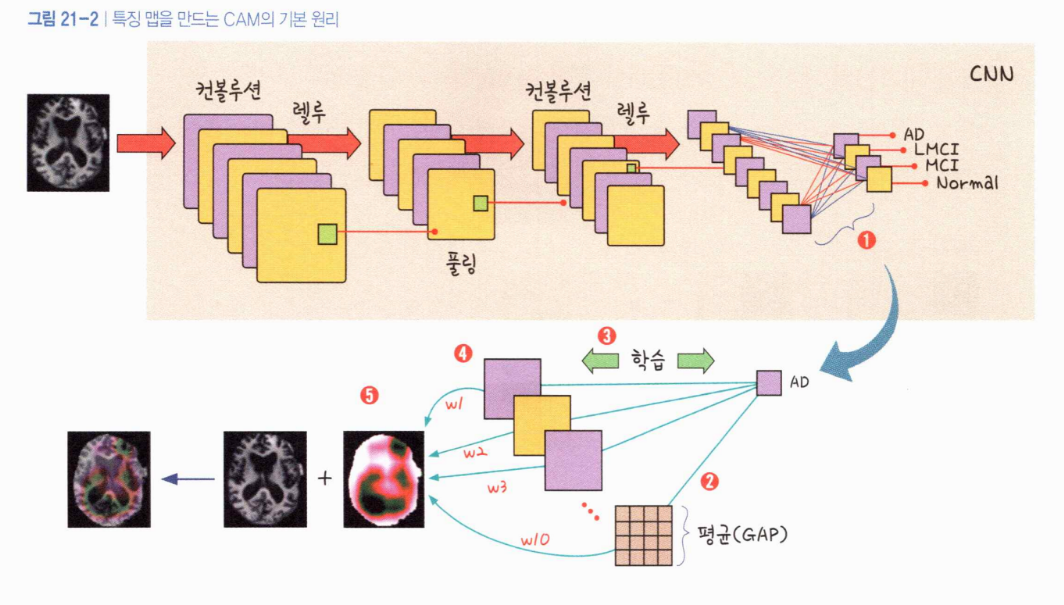

In [1]:
from IPython.display import Image
Image('./ch21_CAM.png')

- CAM

1. 데이터를 1차원으로 축소시키는 Flatten 단계 직전에 개입, 그때까지 만들어진 중간 맵들을 따로 모음
2. 중간 맵들 각각으로부터 평균값(Global Max Pooling, GAP)을 뽑은 후
3. 이 평균값과 최종 예측 사이에서 한 번 더 학습
4. **어떤 벡터가 최종 결정에 가장 큰 영향을 주는지 알려주는 가중치** 얻음
5. 이 가중치를 각 중간맵에 곱함 -> 중요한 맵 가중, 불필요맵 삭제

* 맵=벡터


- 평균값 대신 기울기 사용 -> 그레디언트 CAM(Gradient CAM)

- transformer url
https://wikidocs.net/35596


### 02 설명 가능한 딥러닝의 실행

- 오클루젼 민감도 : 일부를 가리며(폐쇄) 가려진 부분의 영향도 구함

- 라이브러리

    - tf-explain : 설명 가능한 딥러닝 방식 구현
    - OpenCV : 위를 도움 -> 이미지 다룰 때 필수 라이브러리

In [6]:
# !pip install tf-explain

In [2]:
# !pip install opencv-python

                                              0.0/38.2 MB ? eta -:--:--
                                              0.0/38.2 MB ? eta -:--:--
                                              0.0/38.2 MB ? eta -:--:--
                                             0.0/38.2 MB 435.7 kB/s eta 0:01:28
                                              0.1/38.2 MB 1.0 MB/s eta 0:00:37
                                              0.5/38.2 MB 3.3 MB/s eta 0:00:12
                                              0.7/38.2 MB 3.5 MB/s eta 0:00:11
                                              0.7/38.2 MB 3.5 MB/s eta 0:00:11
                                              0.7/38.2 MB 3.5 MB/s eta 0:00:11
     -                                        1.0/38.2 MB 3.0 MB/s eta 0:00:13
     -                                        1.1/38.2 MB 3.2 MB/s eta 0:00:12
     -                                        1.2/38.2 MB 2.8 MB/s eta 0:00:14
     -                                        1.4/38.2 MB 2.8 MB/s eta 0

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16


from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
images_originals = []

for img_path in glob.glob('../data/img/*_0.jpg'):
    images_originals.append(mpimg.imread(img_path))

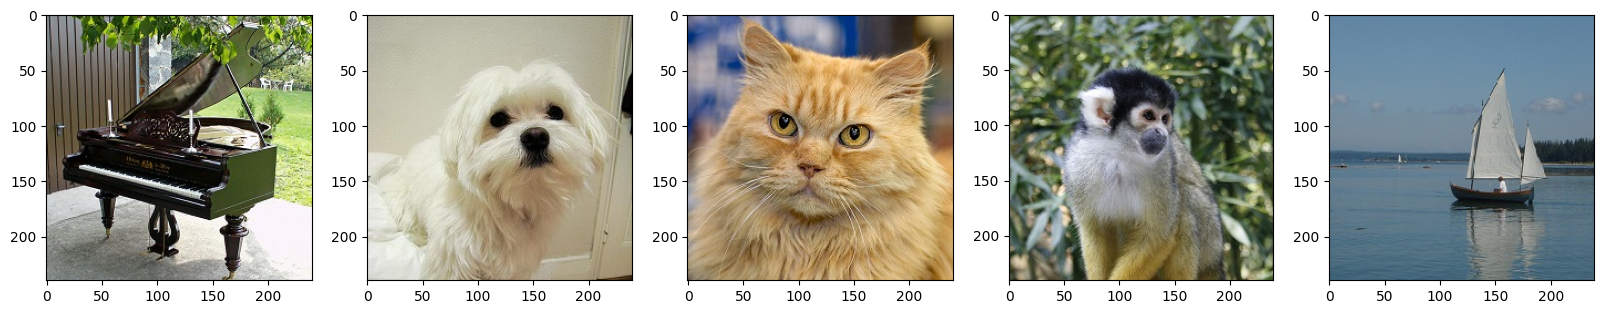

In [5]:
plt.figure(figsize=(20,20))

for i,image_o in enumerate(images_originals):
    plt.subplot(5,5,i+1)
    plt.imshow(image_o)

In [6]:
# 사전 학습된 딥러닝 모델

model = VGG16(weights='imagenet',include_top=True)

553467096/553467096 [==============================] - 281s 1us/step


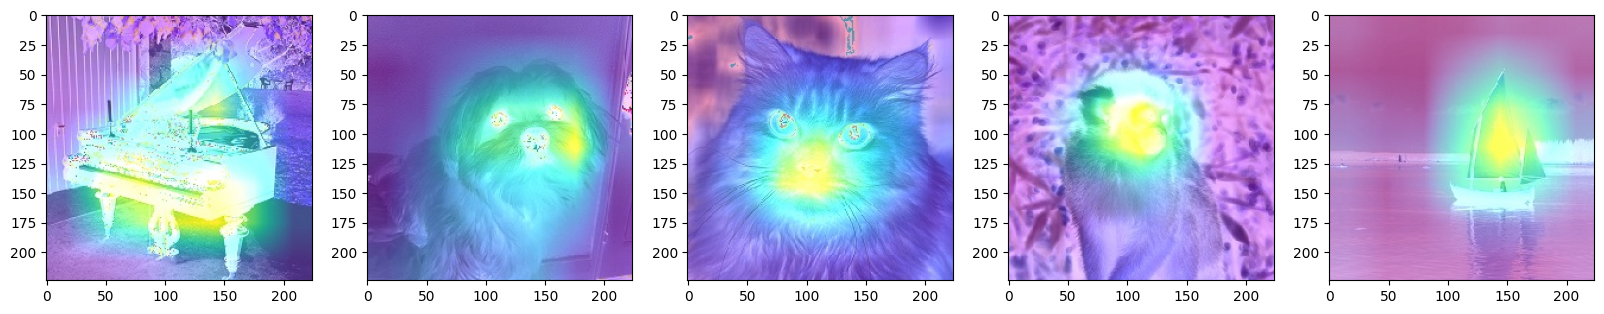

In [7]:
# 원본 이미지 이름과 Imagenet에서의 해당 이미지 인덱스
input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = ["153", "283", "382", "579", "914"]


# 그레이디언트 CAM 알고리즘 선택
explainer = GradCAM()


# 그레이디언트 CAM 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_cams = []


# 그레이디언트 CAM 알고리즘 실행
for l, i in zip(input_list, imagenet_index):  
    img = load_img('../data/img/{}_0.jpg'.format(l), target_size=(224, 224)) # 이미지를 불러오고 내부에서 처리될 이미지의 크기를 설정합니다.
    img = img_to_array(img) # 이미지를 넘파이 배열로 바꾸어 줍니다.
    data = ([img], None)
    grid = explainer.explain(data, model, int(i))                 # 그레이디언트 CAM이 실행되는 부분입니다.
    explainer.save(grid, ".", '../data/img/{}_cam.jpg'.format(l)) # 실행 후 저장되는 이름입니다.


# 그레이디언트 CAM 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))


for img_path in glob.glob('../data/img/*_cam.jpg'):
    images_cams.append(mpimg.imread(img_path))


for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_c)

2/2 [==============================] - 8s 1s/step


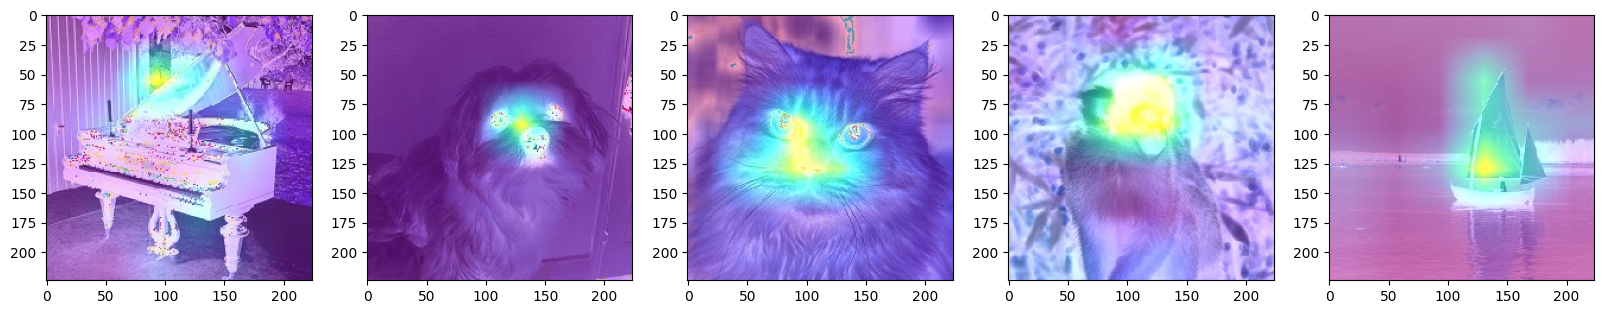

In [8]:
# 오클루전 알고리즘을 불러와 실행합니다.
explainer = OcclusionSensitivity()


# 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_occ1s = []


# 패치 사이즈를 정합니다.
patch_size = 40


# 오클루전 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('../data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size) #패치 사이즈의 설정이 추가됩니다.
    explainer.save(grid, ".", '../data/img/{}_occ1.jpg'.format(l))


# 오클루전 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))


for img_path in glob.glob('../data/img/*_occ1.jpg'):
    images_occ1s.append(mpimg.imread(img_path))


for i, image in enumerate(images_occ1s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
